# KNN (K-Nearest Neighbors) Algoritması

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

İris veri setini yüklendi

---

In [2]:
df = sns.load_dataset("iris")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Veri setindeki numerik veriler normalizasyon işlemi için ayrıldı.

---

In [3]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

Veri setine min-max normalizasyonu uygulandı

---

In [4]:
normalized_df = (df_numeric - df_numeric.min()) / (df_numeric.max() - df_numeric.min())

In [5]:
normalized_df['species'] = df['species']
normalized_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.222222,0.625000,0.067797,0.041667,setosa
1,0.166667,0.416667,0.067797,0.041667,setosa
2,0.111111,0.500000,0.050847,0.041667,setosa
3,0.083333,0.458333,0.084746,0.041667,setosa
4,0.194444,0.666667,0.067797,0.041667,setosa
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,virginica
146,0.555556,0.208333,0.677966,0.750000,virginica
147,0.611111,0.416667,0.711864,0.791667,virginica
148,0.527778,0.583333,0.745763,0.916667,virginica


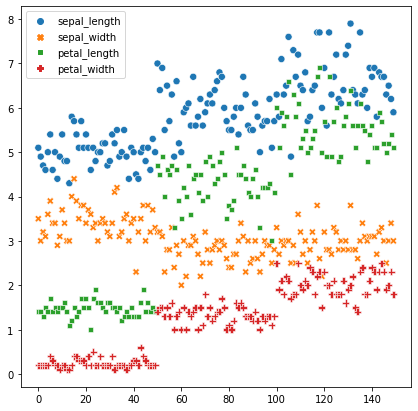

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(data=df_numeric, s=50)
plt.show()

Normalize edilmiş verilerin bulunduğu dataframe test ve eğitim seti olmak üzere ikiye bölündü

---

In [7]:
train = normalized_df.sample(frac=0.6, random_state=450)
test = normalized_df.drop(train.index)
# train, test = train_test_split(df, test_size=0.8)

In [8]:
train['species'].value_counts()

setosa        33
virginica     29
versicolor    28
Name: species, dtype: int64

In [9]:
test['species'].value_counts()

versicolor    22
virginica     21
setosa        17
Name: species, dtype: int64

Get Distance Metotu
---

> Verilen kolonlardaki değerelere göre <b>Manhattan, Euclidean <small>ve</small> Minkowski</b> uzaklarını hesaplayan fonksiyon.

<hr>

*   Manhattan &emsp; &rarr; &emsp; p  &mdash;  1
*   Euclidean &emsp; &rarr; &emsp; p  &mdash;  2
*   Minkowski (3) &emsp; &rarr; &emsp; p  &mdash;  3
*   Minkowski (4) &emsp; &rarr; &emsp; p  &mdash;  4




In [10]:
def get_distince(features: list, p: float, columns=train):
    numeric = columns.select_dtypes(include=['float64', 'int64'])
    values = []

    for feature, column in zip(features, numeric.columns):
        values_col = []

        for index in numeric.index:
            values_col.append(abs((numeric[column][index] - feature)))

        values.append(values_col)

    distinces = []

    for row in zip(*values):
        total = 0
        for value in row:
            total += value ** p

        distinces.append((total ** (1 / p)))

    return distinces

Get Tag Metotu
---
> Verilen etiket tablosundaki verileri uzaklık ağırlığına göre çıkardığı en fazla yakınlık ilişkisi olan etiketi döndüren fonksiyondur.
>> Herhangi bir ağırlık tablosu verilmediğinde bütün verileri çarpma işleminde etkisiz eleman olan 1 le doldurur ve sadece etiket sayısına göre çalışır.

In [11]:
def get_tag(tags: list, weights=None):

    results = {}
    tags = list(tags)

    for tag in tags:
        results[tag] = 0

    if weights is None:
        weights = [1 for x in range(len(tags))]
    else:
        weights = list(weights)

    for i in range(len(tags)):
        if weights[i] == 0:
            weights[i] = 0.000001
        results[tags[i]] += 1 / (weights[i] ** 2)

    tag, weight = tags[0], weights[0]

    for i, j in results.items():
        if j > weight:
            weight = j
            tag = i

    return tag

Verilerin sözük yapısına kaydedilmesi
---
> Bu kısımda k değeri (en yakın komşu sayısı) **1'den 10'a** kadar çalışır.
>> Her **k** değeri için test veri setindeki her satır **KNN** algoritmasına tabii tutulur. <br>
>>> **Manhattan**, **Euclidean** ve 2 **Minkowski** uzaklık değerine göre **4 farklı** etiketleme yapılır ve  doğrulukları test edilir.







In [12]:
results = {'total guesses' : len(test['species'])}

for k in range(1,11):

    results[f'k{k}'] = {}
    results[f'k{k}']['guesses'] = {}
    results[f'k{k}']['correct guesses'] = {}


    for index in test.index:

        tag = test.at[index, 'species']
        sepal_length = test.at[index, 'sepal_length']
        sepal_width = test.at[index, 'sepal_width']
        petal_length = test.at[index, 'petal_length']
        petal_width = test.at[index, 'petal_width']

        temporary_df = train
        features = [sepal_length, sepal_width, petal_length, petal_width]

        for i in range(1,5):
            temporary_df[f'd{i}'] = get_distince(features=features, p=i)
            sorted_temporary = temporary_df.iloc[(temporary_df[f'd{i}']).argsort()]

            guess = get_tag(tags=sorted_temporary['species'].head(k), weights=sorted_temporary[f'd{i}'].head(k))

            if not f'd{i}' in results[f'k{k}']['guesses'].keys():
                results[f'k{k}']['guesses'][f'd{i}'] = {}

            if not f'd{i}' in results[f'k{k}']['correct guesses'].keys():
                results[f'k{k}']['correct guesses'][f'd{i}'] = {}

            if not guess in results[f'k{k}']['guesses'][f'd{i}'].keys():
                results[f'k{k}']['guesses'][f'd{i}'][guess] = 1
            else:
                results[f'k{k}']['guesses'][f'd{i}'][guess] += 1

            if not guess in results[f'k{k}']['correct guesses'][f'd{i}'].keys():
                results[f'k{k}']['correct guesses'][f'd{i}'][guess] = 0

            if guess == tag:
                    results[f'k{k}']['correct guesses'][f'd{i}'][guess] += 1

Sonuçların Ekrana Yazılması 
---

In [13]:
for key in results.keys():

    if key != 'total guesses':
        guesses = results[key]['guesses']
        correct_guesses = results[key]['correct guesses']

        text = f"{key}\t"
        for d in guesses:
            dg = dict(guesses[d])
            dcg = dict(correct_guesses[d])

            for tag in dg.keys():
                total = sum(dcg.values())
                text +=  "{:6.2f}".format((dcg[tag] / dg[tag]))

                if tag == list(dg.keys())[-1]:
                    text += "\t|| %{:.1f} ||\t".format((total / results['total guesses'] * 100))
        print(text)

k1	  1.00  0.95  0.91	|| %95.0 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.88	|| %95.0 ||	  1.00  1.00  0.88	|| %95.0 ||	
k2	  1.00  0.95  0.91	|| %95.0 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.88	|| %95.0 ||	  1.00  1.00  0.88	|| %95.0 ||	
k3	  1.00  0.95  0.91	|| %95.0 ||	  1.00  0.95  0.91	|| %95.0 ||	  1.00  0.95  0.91	|| %95.0 ||	  1.00  0.95  0.91	|| %95.0 ||	
k4	  1.00  0.95  0.91	|| %95.0 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	
k5	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	
k6	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	
k7	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	
k8	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  1.00  0.91	|| %96.7 ||	  1.00  

> **k** Değerlerinin mesafe algoritmalarına göre değişimi ve etiketler üzerindeki doğruluk oranları

<br>

*   seto &emsp;&rarr;&emsp; Setosa
*   verc &emsp;&rarr;&emsp; Versicolor
*   virg &nbsp;&emsp;&rarr;&emsp; Virginica
*   avg  &nbsp;&emsp;&rarr;&emsp; Doğruluk oranı

<br> 
<hr>

**Tablo 1 ve 2 arasındaki temel fark eğitim ve test veri setlerinin farklılığıdır.**
<br> <br> 

<img src='https://www.linkpicture.com/q/genel.png' type='image'>
<img src='https://www.linkpicture.com/q/genel2.png' type='image'>